### MODULES IMPORTING

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import glob
from pathlib import Path

import tensorflow as tf

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [2]:
plt.style.use('ggplot')
seed=42
tf.random.set_seed(seed)

### FILE IMPORTING AND DATA READING


In [3]:
image_path = list(Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset').glob(r'**/*.png'))

image_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],image_path))

In [4]:
image_path = pd.Series(image_path,name='path').astype(str)
image_labels = pd.Series(image_labels,name='label')

In [5]:
df_image = pd.concat([image_path,image_labels],axis=1)

In [6]:
df_image.head()

,path,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel


In [7]:
#shuffle dataset
df_image= df_image.sample(frac=1).reset_index(drop=True)

In [8]:
df_image.head()

,path,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Sea Bass GT
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat GT
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat


In [9]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18000 non-null  object
 1   label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


In [10]:
df_image.label.value_counts()

Sea Bass GT              1000
Black Sea Sprat GT       1000
Red Sea Bream GT         1000
Red Mullet               1000
Gilt-Head Bream GT       1000
Trout GT                 1000
Gilt-Head Bream          1000
Shrimp GT                1000
Striped Red Mullet GT    1000
Sea Bass                 1000
Trout                    1000
Striped Red Mullet       1000
Red Mullet GT            1000
Hourse Mackerel GT       1000
Black Sea Sprat          1000
Red Sea Bream            1000
Hourse Mackerel          1000
Shrimp                   1000
Name: label, dtype: int64

It looks like some pictures are labeled with 'GT'. By reading the Dataset documentation, we understand that GT stands for 'Ground Truth'

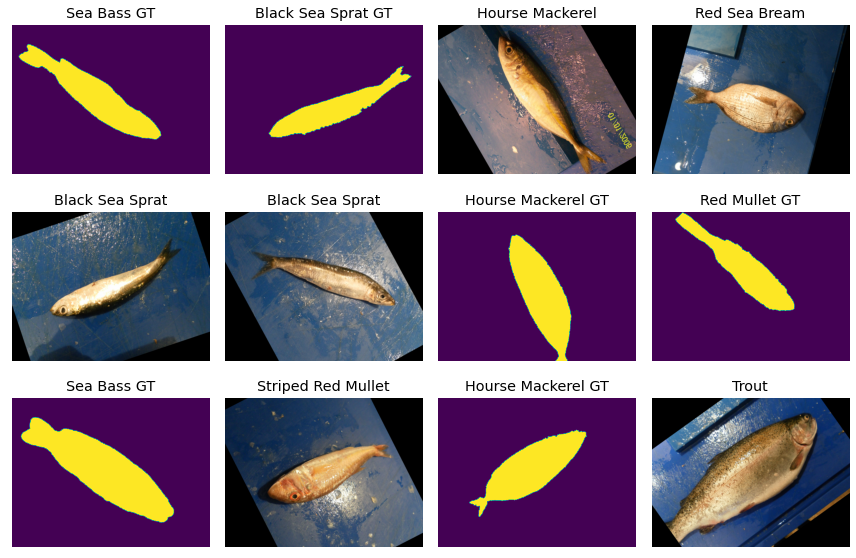

In [11]:
#plotting pictures of fish 

fig,axes = plt.subplots(3,4,figsize=(12,8),subplot_kw= {'xticks':[], 'yticks':[]})

for idx,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_image.path[idx]))
    ax.set_title(df_image.label[idx])
    
plt.tight_layout()
plt.show();

We should definitely remove these GT pictures.

In [12]:
df = df_image[~df_image.label.str.contains("GT")]

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 2 to 17998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 210.9+ KB


In [14]:
df.head()

,path,label
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
5,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
9,../input/a-large-scale-fish-dataset/Fish_Datas...,Striped Red Mullet


The final datset has 9000 pictures. This means that each class had the GT version of pictures, which we removed.

### DATA PREPARATION:

Before feeding the images to the model, we need to define generators for the images!

In [15]:
df = df.sample(frac=1).reset_index(drop=True)

In [16]:
#train test split
df_train,df_test = train_test_split(df,test_size=0.1,random_state=seed)

print('Training size: {} images. \nTest size: {} images.'.format(len(df_train),len(df_test)))

Training size: 8100 images. 
Test size: 900 images.


#### Defining Generators

In [17]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2)

In [18]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input)

In [19]:
train_images= train_generator.flow_from_dataframe(dataframe= df_train,
                                                 x_col='path',
                                                 y_col='label',
                                                 color_mode='rgb',
                                                 class_mode='categorical',
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 shuffle=True,
                                                 seed=seed,
                                                 subset='training')

Found 6480 validated image filenames belonging to 9 classes.


In [20]:
val_images = train_generator.flow_from_dataframe(dataframe=df_train,
                                                x_col='path',
                                                y_col='label',
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                target_size=(224,224),
                                                batch_size=64,
                                                shuffle=True,
                                                seed=seed,
                                                subset='validation')

Found 1620 validated image filenames belonging to 9 classes.


In [21]:
test_images = test_generator.flow_from_dataframe(dataframe=df_test,
                                                x_col='path',
                                                y_col='label',
                                                color_mode='rgb',
                                                class_mode='categorical',
                                                target_size=(224,224),
                                                batch_size=64,
                                                shuffle=False)

Found 900 validated image filenames belonging to 9 classes.


### Model definition: MobileNETV2 fine tuning

We define a 'create model' function with the base model (MobileNETV2) and two additional dense layers: one hidden layer with 32 neurons and the output layers with 9 layers, since there are 9 classes to be classified.

In [22]:
def create_model(input_shape=(224,224,3)):
    inputs= tf.keras.layers.Input(input_shape)
    
    #import the base MobileNetV2 model with imagenet weeights
    base_model = tf.keras.applications.MobileNetV2(input_shape=(224,224,3),
                                                   weights='imagenet',
                                                   pooling='avg',
                                                   include_top=False)
    
    #only train the last 2 layers to be added.
    base_model.trainable = False
    
    #add extra layers and create model structure
    x=base_model(inputs)
    x= tf.keras.layers.Dense(32,activation='relu')(x)
    outputs= tf.keras.layers.Dense(9,activation='softmax')(x)
    
    model = tf.keras.models.Model(inputs,outputs)
    
    return model

In [23]:
model = create_model(input_shape=(224,224,3))

2023-01-29 13:34:01.240661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 13:34:01.249462: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 13:34:01.250151: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 13:34:01.251227: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

### MODEL TRAINING

In [24]:
model.compile(optimizer='adam',loss='categorical_crossentropy',
             metrics=['accuracy'])

In [25]:
history = model.fit(train_images,
                   validation_data = val_images,
                   epochs=5,
                   callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=1,restore_best_weights=True)])

2023-01-29 13:34:04.843970: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2023-01-29 13:34:08.280066: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


102/102 [==============================] - 97s 913ms/step - loss: 0.4427 - accuracy: 0.8772 - val_loss: 0.0736 - val_accuracy: 0.9889
Epoch 2/5
102/102 [==============================] - 92s 900ms/step - loss: 0.0389 - accuracy: 0.9965 - val_loss: 0.0346 - val_accuracy: 0.9951
Epoch 3/5
102/102 [==============================] - 92s 903ms/step - loss: 0.0185 - accuracy: 0.9997 - val_loss: 0.0235 - val_accuracy: 0.9957
Epoch 4/5
102/102 [==============================] - 93s 911ms/step - loss: 0.0112 - accuracy: 0.9997 - val_loss: 0.0171 - val_accuracy: 0.9969
Epoch 5/5
102/102 [==============================] - 93s 914ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 0.0119 - val_accuracy: 0.9988


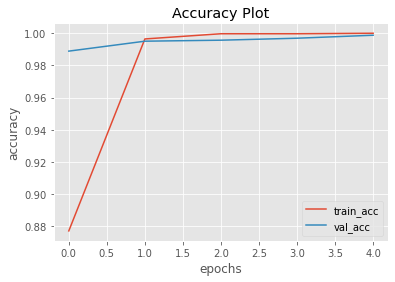

In [26]:
#accuracy plot
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title('Accuracy Plot')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

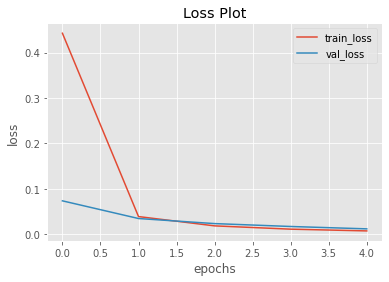

In [27]:
#loss plot
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title('Loss Plot')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Loss and Accuracy look great ! Now we should check the performance on the test set !

### MODEL TESTING

In [28]:
results = model.evaluate(test_images)

15/15 [==============================] - 10s 681ms/step - loss: 0.0109 - accuracy: 1.0000


In [29]:
print('Training Accuracy: {:.2f}%'.format(history.history["accuracy"][-1:][0]*100))
print('Validation Accuracy: {:.2f}%'.format(history.history["val_accuracy"][-1:][0]*100))
print('Testing Accuracy: {:.2f}%'.format(results[1]*100))

Training Accuracy: 100.00%
Validation Accuracy: 99.88%
Testing Accuracy: 100.00%


### MODEL PREDICTION : FISH RECOGNITON

In [30]:
pred= model.predict(test_images)

In [31]:
pred[0]

array([9.9946719e-01, 2.8570303e-06, 3.8746858e-04, 7.5122085e-07,
       1.2787347e-05, 6.4016508e-06, 3.2387041e-05, 9.0194328e-05,
       1.5521941e-08], dtype=float32)

In [32]:
[i * 100 for i in pred[0]] # we multiply by 100 to transform these values into probabilities with percentage

[99.94671940803528,
 0.0002857030267477967,
 0.03874685789924115,
 7.51220852635015e-05,
 0.0012787347259290982,
 0.0006401650807674741,
 0.0032387040846515447,
 0.009019432764034718,
 1.5521941065799183e-06]

The model predicts that the first image in the test set correponds to the fifth class with a probability of 97%
In order to keep the most likely label for each predicted label, we will use 'np.argmax' function from numpy library.

In [33]:
pred = np.argmax(pred,axis=1)

In [34]:
labels_1 = (train_images.class_indices)
labels_1

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

By calling the class_indices method on train_images, we can see that we get a dictionary where the keys are the classes and the values are the indexes.
We actually want to switch the keys with the values!

In [35]:
labels = {y:x for x, y in labels_1.items()}
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

In [36]:
pred = [labels[idx] for idx in pred] # create a list of the predicted labels

In [37]:
#classification report

y_test = list(df_test.label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00       105
   Gilt-Head Bream       1.00      1.00      1.00       108
   Hourse Mackerel       1.00      1.00      1.00        80
        Red Mullet       1.00      1.00      1.00       103
     Red Sea Bream       1.00      1.00      1.00        81
          Sea Bass       1.00      1.00      1.00       103
            Shrimp       1.00      1.00      1.00        96
Striped Red Mullet       1.00      1.00      1.00       115
             Trout       1.00      1.00      1.00       109

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



All test images are corrrectly predicted by the net created.

In [38]:
#confusion_matrix
conf_matrix = confusion_matrix(y_test, pred, normalize='true')

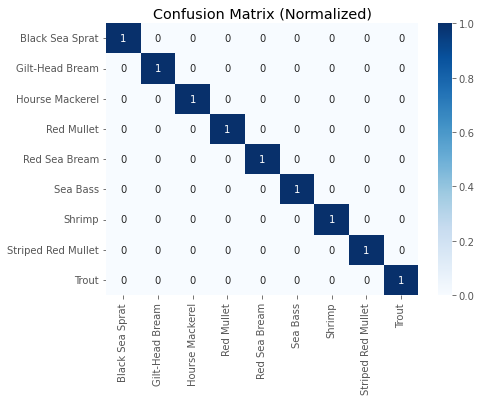

In [39]:
plt.figure(figsize = (7,5))
sns.heatmap(conf_matrix, cmap='Blues',annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix (Normalized)')
plt.show()

### DISPLAYING PREDICTED RESULTS:

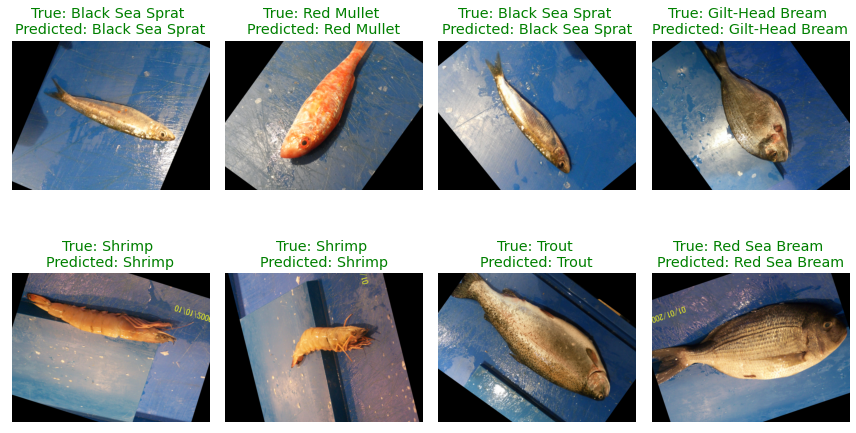

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.path.iloc[idx]))
    ax.set_title("True: {} \nPredicted: {}".format(df_test.label.iloc[idx], pred[idx]), color=("green" if pred[idx]==df_test.label.iloc[idx] else "red"))
plt.tight_layout()
plt.show()

Nice. Siuu !